In [1]:
!pip install seawater

  Using cached seawater-3.3.4-py3-none-any.whl


In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:33011")
client

<Client: 'tcp://127.0.0.1:33011' processes=8 threads=64, memory=235.96 GiB>

In [3]:
client.restart()

<Client: 'tcp://127.0.0.1:44153' processes=0 threads=0, memory=0 B>

In [3]:
import numpy as np
import xarray as xr
from xgcm.grid import Grid
from fastjmd95 import rho  # JMD95
import seawater as sw      # EOS80
import gsw

In [4]:
import intake
import os
import gcsfs

gcs = gcsfs.GCSFileSystem(requester_pays=True)

SCRATCH = os.environ['SCRATCH_BUCKET']
SCRATCH

'gcs://meom-ige-scratch/roxyboy'

In [5]:
from validate_catalog import all_params
params_dict, cat = all_params()
params_dict.keys()

dict_keys(['GIGATL', 'HYCOM50', 'eNATL60', 'FESOM', 'ORCA36'])

In [6]:
for entry in params_dict.keys():
    print(f"{entry} parameters and their allowable args are:")
    description = cat[entry].describe()
    params = description["user_parameters"]
    if len(params) != 0:
        for i in range(len(params)):
            print(f"""    {params[i]["name"]}: {params[i]["allowed"]}""")            
    else:
        print("    Not implemented.")
    print()

GIGATL parameters and their allowable args are:
    region: ['1', '2']
    datatype: ['surf', 'int']
    season: ['fma', 'aso']

HYCOM50 parameters and their allowable args are:
    region: ['1_GS', '2_GE', '3_MD']
    datatype: ['surf', 'int', 'grid']
    season: ['fma', 'aso', '']
    grid: ['grid', '']

eNATL60 parameters and their allowable args are:
    region: ['1', '2', '3']
    datatype: ['surface_hourly', 'interior_daily']
    season: ['fma', 'aso']

FESOM parameters and their allowable args are:
    datatype: ['surf', 'int']
    season: ['fma', 'aso']

ORCA36 parameters and their allowable args are:
    region: ['1', '2', '3', '4']
    datatype: ['surface_hourly', 'interior_daily', 'grid']
    season: ['fma', 'aso', '']
    grid: ['bathymetry', 'meshmask', '']



# eNATL60

In [ ]:
enatl01w = cat.eNATL60(region='1',datatype='interior_daily', season='fma').to_dask()
enatl01s = cat.eNATL60(region='1',datatype='interior_daily', season='aso').to_dask()
enatl01s

In [8]:
sig0w = xr.apply_ufunc(gsw.sigma0, enatl01w.vosaline, enatl01w.votemper,
                       dask='parallelized', output_dtypes=[float,]
                      )
sig0s = xr.apply_ufunc(gsw.sigma0, enatl01s.vosaline, enatl01s.votemper,
                       dask='parallelized', output_dtypes=[float,]
                      )
sig0s

<xarray.DataArray (time_counter: 92, deptht: 107, y: 763, x: 611)>
dask.array<transpose, shape=(92, 107, 763, 611), dtype=float64, chunksize=(1, 107, 15, 611), chunktype=numpy.ndarray>
Coordinates: (12/15)
    depth         (y, x) float32 dask.array<chunksize=(15, 611), meta=np.ndarray>
  * deptht        (deptht) float32 0.4805 1.559 2.794 ... 968.4 985.3 1.002e+03
    e1f           (y, x) float64 dask.array<chunksize=(15, 611), meta=np.ndarray>
    e1t           (y, x) float64 dask.array<chunksize=(15, 611), meta=np.ndarray>
    e1u           (y, x) float64 dask.array<chunksize=(15, 611), meta=np.ndarray>
    e1v           (y, x) float64 dask.array<chunksize=(15, 611), meta=np.ndarray>
    ...            ...
    e2v           (y, x) float64 dask.array<chunksize=(15, 611), meta=np.ndarray>
    lat           (y, x) float32 dask.array<chunksize=(15, 611), meta=np.ndarray>
    lon           (y, x) float32 dask.array<chunksize=(15, 611), meta=np.ndarray>
    nav_lat       (y, x) float32 dask.array<chunksize=(15, 611), meta=np.ndarray>
    nav_lon       (y, x) float32 dask.array<chunksize=(15, 611), meta=np.ndarray>
  * time_counter  (time_counter) datetime64[ns] 2009-08-01 ... 2009-10-31
Dimensions without coordinates: y, x

In [9]:
tmp_path = f'{SCRATCH}/region01/eNATL60/'+f'sigma0_fma.zarr'
store_tmp = gcs.get_mapper(tmp_path)
sig0w.to_dataset(name='sig0').to_zarr(store_tmp, mode='w')

tmp_path = f'{SCRATCH}/region01/eNATL60/'+f'sigma0_aso.zarr'
store_tmp = gcs.get_mapper(tmp_path)
sig0s.to_dataset(name='sig0').to_zarr(store_tmp, mode='w')

# GIGATL

In [7]:
# Functions to adapt croco outputs to xgcm
##########################################

def adjust_coords(ds):

    if 'nav_lon_u' not in ds.coords:
        ##########################
        # for regular CROCO files:
        ds = ds.set_coords([c for c in ds.variables if 'lon' in c or 'lat' in c ])

    else:
        ##########################
        # for XIOS files:
        
        ds = ds.rename({'time_counter': 'time'})
        
        ds = ds.reset_coords([c for c in ds.coords if 'nav' in c])

        # rename redundant dimensions
        _dims = (d for d in ['x_v', 'y_u', 'x_w', 'y_w'] if d in ds.dims)
        for d in _dims:
            ds = ds.rename({d: d[0]+'_rho'})

        # change axis names to xi,eta (instead of x,y)
        _dims = (d for d in ['x_u', 'x_rho'] if d in ds.dims)
        for d in _dims:
            ds = ds.rename({d: 'xi' + d[1:]}) 

        _dims = (d for d in ['y_v', 'y_rho'] if d in ds.dims)
        for d in _dims:
            ds = ds.rename({d: 'eta' + d[1:]}) 


        # change nav variables to coordinates        
        _coords = [d for d in [d for d in ds.data_vars.keys()] if "nav_" in d]
        ds = ds.set_coords(_coords) 

        # rename coordinates 
        eta_suff={}
        for c in ds.coords:
            new_c = c.replace('nav_lat','lat').replace('nav_lon','lon')
            ds = ds.rename({c:new_c})
            # reset names and units
            ds[new_c] = (ds[new_c].assign_attrs(units='deg', 
                                               standard_name=new_c,
                                               long_name=new_c)
                        )

    ##########################
    # For all types  
    if 'eta_psi' in ds.dims: ds = ds.rename({'eta_psi': 'eta_v'}) 
    if 'xi_psi' in ds.dims: ds = ds.rename({'xi_psi': 'xi_u'}) 
        

    ##########################
    # Create xgcm grid
    coords={'xi':{'center':'xi_rho', 'inner':'xi_u'}, 
            'eta':{'center':'eta_rho', 'inner':'eta_v'}, 
            's':{'center':'s_rho', 'outer':'s_w'}}

    ds.attrs['xgcm-Grid'] = Grid(ds, coords=coords, periodic=[])


    return ds

    
def add_grd(ds,grd):
    
    ##########################
    for variable in grd.data_vars.keys():
        #print(variable)
        ds[variable] = grd[variable]
        
    ds['mask_rho'] = ds.mask_rho.where(ds.mask_rho>0,np.nan)
    
    if 'lon_psi' not in ds.coords: 
        #ds['lon_psi'] = grd['lon_psi']
        #ds['lat_psi'] = grd['lat_psi']
        ds = ds.assign_coords({'lon_psi':grd['lon_psi'], 'lat_psi':grd['lat_psi']})

    return ds
 
    ########

def dll_dist(dlon, dlat, lon, lat):
    """
    Converts lat/lon differentials into distances in meters
    
    parameters:
        dlon : xarray.DataArray longitude differentials 
        dlat : xarray.DataArray latitude differentials 
        lon : xarray.DataArray longitude values
        lat : xarray.DataArray latitude values
    returns:
        dx : xarray.DataArray distance inferred from dlon 
        dy : xarray.DataArray distance inferred from dlat 
    """
    
    distance_1deg_equator = 111000.0
    dx = dlon * xr.ufuncs.cos(xr.ufuncs.deg2rad(lat)) * distance_1deg_equator 
    dy = ((lon * 0) + 1) * dlat * distance_1deg_equator
    return dx, dy


###################################

def add_vertical_coord(ds):
    
    if ds.VertCoordType=='NEW':
        ds['Vtransform'] = 2
    else:
        ds['Vtransform'] = 1

    #####################
    
    ds['sc_r'] = xr.DataArray(ds.sc_r,  dims=["s_rho"])
    ds['sc_w'] = xr.DataArray(ds.sc_w,  dims=["s_w"])
    ds['Cs_r'] = xr.DataArray(ds.Cs_r,  dims=["s_rho"])
    ds['Cs_w'] = xr.DataArray(ds.Cs_w,  dims=["s_w"])

    #####################
    # Including vertical coordinates

    if ds.Vtransform == 1:
        Zo_rho = ds.hc * (ds.sc_r - ds.Cs_r) + ds.Cs_r * ds.h
        z_rho = Zo_rho + ds.zeta * (1 + Zo_rho/ds.h)
    elif ds.Vtransform == 2:
        Zo_rho = (ds.hc * ds.sc_r + ds.Cs_r * ds.h) / (ds.hc + ds.h)
        z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho; del Zo_rho

    ds.coords['z_rho'] = z_rho  * ds.mask_rho

    if ds.Vtransform == 1:
        Zo_w = ds.hc * (ds.sc_w - ds.Cs_w) + ds.Cs_w * ds.h
        z_w = Zo_rho + ds.zeta * (1 + Zo_w/ds.h)
    elif ds.Vtransform == 2:
        Zo_w = (ds.hc * ds.sc_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
        z_w = ds.zeta + (ds.zeta + ds.h) * Zo_w; del Zo_w

    ds.coords['z_w'] = z_w  * ds.mask_rho
    
    return ds


###################################
    
def _compute_metrics_curvilinear(ds):
    """
    Create a xgcm grid and set it in the dataset as a attribute

    Parameters:
        ds : xarray dataset
    returns:
        ds : xarray dataset with the xgcm  grid
        grid : xgcm grid
    """

    # curvilinear grid
    # Create xgcm grid without any metrics
    coords={'x':{'center':'xi_rho',  'inner':'xi_u'}, 
            'y':{'center':'eta_rho', 'inner':'eta_v'}, 
            'z':{'center':'s_rho',   'outer':'s_w'}}

    grid = Grid(ds, 
              coords=coords,
              boundary='extend')

    # Computes lon/lat at u,v and psi points, and assign to the dataset as coordinates
    ds['lon_u'] = grid.interp(ds.lon_rho,'x')
    ds['lat_u'] = grid.interp(ds.lat_rho,'x')
    ds['lon_v'] = grid.interp(ds.lon_rho,'y')
    ds['lat_v'] = grid.interp(ds.lat_rho,'y')
    ds['lon_psi'] = grid.interp(ds.lon_v,'x')
    ds['lat_psi'] = grid.interp(ds.lat_u,'y')
    _coords = ['lon_u','lat_u','lon_v','lat_v','lon_psi','lat_psi']
    ds = ds.set_coords(_coords)
    
    # Computes lon/lat at u,v and psi points, and assign to the dataset as coordinates
    ds['z_u'] = grid.interp(ds.z_rho,'x')
    ds['z_v'] = grid.interp(ds.z_rho,'y')
    _coords = ['z_u','z_v']
    ds = ds.set_coords(_coords)
    

    # add horizontal distance metrics for rho, u, v and psi point
    if 'pm' in ds and 'pn' in ds:
        ds['dx_rho'] = 1/ds['pm']
        ds['dy_rho'] = 1/ds['pn']
    else: # backward compatibility, hack
        dlon = grid.interp(grid.diff(ds.lon_rho,'x'),'x')
        dlat =  grid.interp(grid.diff(ds.lat_rho,'y'),'y')
        ds['dx_rho'], ds['dy_rho'] = dll_dist(dlon, dlat, ds.lon_rho, ds.lat_rho)
    
    dlon = grid.interp(grid.diff(ds.lon_u,'x'),'x')
    dlat = grid.interp(grid.diff(ds.lat_u,'y'),'y')
    ds['dx_u'], ds['dy_u'] = dll_dist(dlon, dlat, ds.lon_u, ds.lat_u)
    dlon = grid.interp(grid.diff(ds.lon_v,'x'),'x')
    dlat = grid.interp(grid.diff(ds.lat_v,'y'),'y')
    ds['dx_v'], ds['dy_v'] = dll_dist(dlon, dlat, ds.lon_v, ds.lat_v)
    dlon = grid.interp(grid.diff(ds.lon_psi,'x'),'x')
    dlat = grid.interp(grid.diff(ds.lat_psi,'y'),'y')
    ds['dx_psi'], ds['dy_psi'] = dll_dist(dlon, dlat, ds.lon_psi, ds.lat_psi)

    
    ds['mask_psi'] = grid.interp(grid.interp(ds.mask_rho, 'y'),  'x') 
    
    # add vertical metrics for u, v, rho and psi points
    ds['dz_rho'] = grid.diff(ds.z_w,'z')
    ds['dz_w']   = grid.diff(ds.z_rho,'z')
    ds['dz_u']   = grid.interp(ds.dz_rho,'x')
    ds['dz_v']   = grid.interp(ds.dz_rho,'y')
    ds['dz_psi'] = grid.interp(ds.dz_v,'x')

    # add areas metrics for rho,u,v and psi points
    ds['rArho'] = ds.dx_psi * ds.dy_psi
    ds['rAu']   = ds.dx_v   * ds.dy_v
    ds['rAv']   = ds.dx_u   * ds.dy_u
    ds['rApsi'] = ds.dx_rho * ds.dy_rho

    metrics = {
           ('x',): ['dx_rho', 'dx_u', 'dx_v', 'dx_psi'], # X distances
           ('y',): ['dy_rho', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
           ('z',): ['dz_rho', 'dz_u', 'dz_v', 'dz_psi', 'dz_w'], # Z distances
           ('x', 'y'): ['rArho', 'rAu', 'rAv', 'rApsi'] # Areas
          }

    ds.attrs['xgcm-Grid'] = Grid(ds, 
              coords=coords,
              metrics = metrics,
              periodic=False,
              boundary='extend')

    return ds

In [8]:
def rho1_eos(Tt,Ts,g,rho0):
    '''
    compute density from equation of state
    '''

    A00=+19092.56;A01=+209.8925;
    A02=-3.041638;A03=-1.852732e-3;A04=-1.361629e-5;A10=104.4077;
    A11=-6.500517;A12=+0.1553190;A13=2.326469e-4;AS0=-5.587545;
    AS1=+0.7390729;AS2=-1.909078e-2;B00=+4.721788e-1;B01=+1.028859e-2;
    B02=-2.512549e-4;B03=-5.939910e-7;B10=-1.571896e-2;B11=-2.598241e-4;
    B12=+7.267926e-6;BS1=+2.042967e-3;E00=+1.045941e-5;E01=-5.782165e-10;
    E02=+1.296821e-7;E10=-2.595994e-7;E11=-1.248266e-9;E12=-3.508914e-9;

    QR=+999.842594;Q01=+6.793952e-2;Q02=-9.095290e-3;
    Q03=+1.001685e-4;Q04=-1.120083e-6;Q05=+6.536332e-9;Q10=+0.824493;
    Q11=-4.08990e-3;Q12=+7.64380e-5;Q13=-8.24670e-7;Q14=+5.38750e-9;
    QS0=-5.72466e-3;QS1=+1.02270e-4;QS2=-1.65460e-6;Q20=+4.8314e-4;

    sqrtTs=Ts ** 0.5;
    
    K0=A00+Tt*(A01+Tt*(A02+Tt*(A03+Tt*A04)))\
    +Ts*(A10+Tt*(A11+Tt*(A12+Tt*A13))\
    +sqrtTs*(AS0+Tt*(AS1+Tt*AS2)));
    
    K1=B00+Tt*(B01+Tt*(B02+Tt*B03))\
    +Ts*(B10+Tt*(B11+Tt*B12)+sqrtTs*BS1);
    
    K2=E00+Tt*(E01+Tt*E02)\
    +Ts*(E10+Tt*(E11+Tt*E12));
    
    rho1=QR+Tt*(Q01+Tt*(Q02+Tt*(Q03+Tt*(Q04+Tt*Q05))))\
    +Ts*(Q10+Tt*(Q11+Tt*(Q12+Tt*(Q13+Tt*Q14)))\
    +sqrtTs*(QS0+Tt*(QS1+Tt*QS2))+Ts*Q20);

    #######################################################

    return rho1



#######################################################


def rho_eos(Tt,Ts,z_r,g,rho0):
    '''
    compute in-situ density (rho) from equation of state
    '''

    A00=+19092.56;A01=+209.8925;
    A02=-3.041638;A03=-1.852732e-3;A04=-1.361629e-5;A10=104.4077;
    A11=-6.500517;A12=+0.1553190;A13=2.326469e-4;AS0=-5.587545;
    AS1=+0.7390729;AS2=-1.909078e-2;B00=+4.721788e-1;B01=+1.028859e-2;
    B02=-2.512549e-4;B03=-5.939910e-7;B10=-1.571896e-2;B11=-2.598241e-4;
    B12=+7.267926e-6;BS1=+2.042967e-3;E00=+1.045941e-5;E01=-5.782165e-10;
    E02=+1.296821e-7;E10=-2.595994e-7;E11=-1.248266e-9;E12=-3.508914e-9;

    QR=+999.842594;Q01=+6.793952e-2;Q02=-9.095290e-3;
    Q03=+1.001685e-4;Q04=-1.120083e-6;Q05=+6.536332e-9;Q10=+0.824493;
    Q11=-4.08990e-3;Q12=+7.64380e-5;Q13=-8.24670e-7;Q14=+5.38750e-9;
    QS0=-5.72466e-3;QS1=+1.02270e-4;QS2=-1.65460e-6;Q20=+4.8314e-4;

    sqrtTs=Ts ** 0.5;
    
    K0=A00+Tt*(A01+Tt*(A02+Tt*(A03+Tt*A04)))\
    +Ts*(A10+Tt*(A11+Tt*(A12+Tt*A13))\
    +sqrtTs*(AS0+Tt*(AS1+Tt*AS2)));
    
    K1=B00+Tt*(B01+Tt*(B02+Tt*B03))\
    +Ts*(B10+Tt*(B11+Tt*B12)+sqrtTs*BS1);
    
    K2=E00+Tt*(E01+Tt*E02)\
    +Ts*(E10+Tt*(E11+Tt*E12));
    
    rho1=QR+Tt*(Q01+Tt*(Q02+Tt*(Q03+Tt*(Q04+Tt*Q05))))\
    +Ts*(Q10+Tt*(Q11+Tt*(Q12+Tt*(Q13+Tt*Q14)))\
    +sqrtTs*(QS0+Tt*(QS1+Tt*QS2))+Ts*Q20);

    rho=rho1/(1+0.1*z_r/(K0-z_r*(K1-z_r*K2)));

    #######################################################

    return rho


In [9]:
gigatl01w = add_vertical_coord(adjust_coords(cat.GIGATL(region='1', datatype='int', season='fma').to_dask())
                              ).chunk({'eta_rho':200,'eta_v':200,'xi_rho':200,'xi_u':200})
gigatl01s = add_vertical_coord(adjust_coords(cat.GIGATL(region='1', datatype='int', season='aso').to_dask())
                              ).chunk({'eta_rho':200,'eta_v':200,'xi_rho':200,'xi_u':200})
gigatl01w['g'] = 9.81
gigatl01s['g'] = 9.81
gigatl01w

<xarray.Dataset>
Dimensions:     (eta_rho: 1541, eta_v: 1540, s_rho: 100, s_w: 101, time: 89, xi_rho: 1576, xi_u: 1575)
Coordinates:
    lat_rho     (eta_rho, xi_rho) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    lon_rho     (eta_rho, xi_rho) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    z_rho       (time, eta_rho, xi_rho, s_rho) float64 dask.array<chunksize=(1, 200, 200, 100), meta=np.ndarray>
    z_w         (time, eta_rho, xi_rho, s_w) float64 dask.array<chunksize=(1, 200, 200, 101), meta=np.ndarray>
Dimensions without coordinates: eta_rho, eta_v, s_rho, s_w, time, xi_rho, xi_u
Data variables: (12/19)
    angle       (eta_rho, xi_rho) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    f           (eta_rho, xi_rho) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    h           (eta_rho, xi_rho) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    mask_rho    (eta_rho, xi_rho) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    ocean_time  (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    pm          (eta_rho, xi_rho) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    ...          ...
    Vtransform  int64 2
    sc_r        (s_rho) float64 dask.array<chunksize=(100,), meta=np.ndarray>
    sc_w        (s_w) float64 dask.array<chunksize=(101,), meta=np.ndarray>
    Cs_r        (s_rho) float64 dask.array<chunksize=(100,), meta=np.ndarray>
    Cs_w        (s_w) float64 dask.array<chunksize=(101,), meta=np.ndarray>
    g           float64 9.81
Attributes: (12/71)
    Akt_bak:         [0.0, 0.0]
    Akt_bak_expl:    background vertical mixing coefficient for tracers
    Akt_bak_units:   meter2 second-1
    Akv_bak:         0.0
    Akv_bak_expl:    background vertical mixing coefficient for momentum
    Akv_bak_units:   meter2 second-1
    ...              ...
    tnu4_expl:       biharmonic mixing coefficient for tracers
    type:            ROMS restart file
    units:           meter4 second-1
    v_sponge:        0.0
    x_sponge:        0.0
    xgcm-Grid:       <xgcm.Grid>\nxi Axis (not periodic, boundary=None):\n  *...

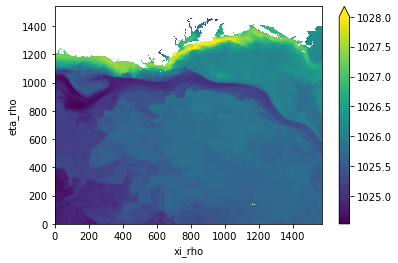

In [18]:
xr.apply_ufunc(rho, 
               gigatl01w.salt.where(gigatl01w.mask_rho!=0.).isel(time=0).reset_coords(drop=True), 
               gigatl01w.temp.where(gigatl01w.mask_rho!=0.).isel(time=0).reset_coords(drop=True), 
               0.,
               dask='parallelized', output_dtypes=[float,]
              ).isel(s_rho=-1).plot(vmax=1028)

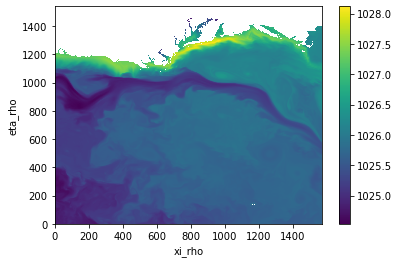

In [15]:
xr.apply_ufunc(rho1_eos, 
               gigatl01w.temp.where(gigatl01w.mask_rho!=0.).isel(time=0).reset_coords(drop=True), 
               gigatl01w.salt.where(gigatl01w.mask_rho!=0.).isel(time=0).reset_coords(drop=True),
               gigatl01w.g, gigatl01w.rho0,
               dask='parallelized', output_dtypes=[float,]
              ).isel(s_rho=-1).plot()

In [43]:
for i in range(88,len(gigatl01w.time)):
    sig0w = xr.apply_ufunc(rho1_eos,  
                           gigatl01w.temp.isel(time=i).where(gigatl01w.mask_rho!=0.).reset_coords(drop=True), 
                           gigatl01w.salt.isel(time=i).where(gigatl01w.mask_rho!=0.).reset_coords(drop=True),
                           gigatl01w.g, gigatl01w.rho0,
                           dask='parallelized', output_dtypes=[float,]
                          ) - 1e3
#     sig0w = xr.apply_ufunc(rho, gigatl01w.salt.where(gigatl01w.mask_rho!=0.).isel(time=i).reset_coords(drop=True), 
#                            gigatl01w.temp.where(gigatl01w.mask_rho!=0.).isel(time=i).reset_coords(drop=True), 
#                            0.,
#                            dask='parallelized', output_dtypes=[float,]
#                           ) - 1e3

    tmp_path = f'{SCRATCH}/region01/GIGATL/'+f'sigma0_fma_%02d.zarr' % i
    store_tmp = gcs.get_mapper(tmp_path)
    sig0w.to_dataset(name='sig0').to_zarr(store_tmp, mode='w')
    
#     if i % 10 == 0:
    print(i)
    client.restart()

88


In [14]:
for i in range(91,len(gigatl01s.time)):
    sig0s = xr.apply_ufunc(rho1_eos, 
                           gigatl01s.temp.isel(time=i).where(gigatl01s.mask_rho!=0.).reset_coords(drop=True), 
                           gigatl01s.salt.isel(time=i).where(gigatl01s.mask_rho!=0.).reset_coords(drop=True), 
                           gigatl01s.g, gigatl01s.rho0,
                           dask='parallelized', output_dtypes=[float,]
                          ) - 1e3
#     sig0s = xr.apply_ufunc(rho, gigatl01s.salt.where(gigatl01s.mask_rho!=0.).isel(time=i).reset_coords(drop=True), 
#                            gigatl01s.temp.where(gigatl01s.mask_rho!=0.).isel(time=i).reset_coords(drop=True), 
#                            0.,
#                            dask='parallelized', output_dtypes=[float,]
#                           ) - 1e3

    tmp_path = f'{SCRATCH}/region01/GIGATL/'+f'sigma0_aso_%02d.zarr' % i 
    store_tmp = gcs.get_mapper(tmp_path)
    sig0s.to_dataset(name='sig0').to_zarr(store_tmp, mode='w')
    
    print(i)
    client.restart()

91


# ORCA36

In [8]:
orca01w = cat.ORCA36(region='1', datatype='interior_daily', season='fma').to_dask().isel(y=slice(None,450))
orca01s = cat.ORCA36(region='1', datatype='interior_daily', season='aso').to_dask().isel(y=slice(None,450))
orca01s

<xarray.Dataset>
Dimensions:               (axis_nbounds: 2, deptht: 47, depthu: 47, depthv: 47, depthw: 47, time_counter: 92, x: 361, y: 450)
Coordinates:
  * deptht                (deptht) float32 0.5058 1.556 ... 947.4 1.046e+03
  * depthu                (depthu) float32 0.5058 1.556 ... 947.4 1.046e+03
  * depthv                (depthv) float32 0.5058 1.556 ... 947.4 1.046e+03
  * depthw                (depthw) float32 0.0 1.024 2.103 ... 814.1 901.1 995.7
    nav_lat               (y, x) float32 dask.array<chunksize=(450, 361), meta=np.ndarray>
    nav_lon               (y, x) float32 dask.array<chunksize=(450, 361), meta=np.ndarray>
    time_centered         (time_counter) datetime64[ns] dask.array<chunksize=(2,), meta=np.ndarray>
  * time_counter          (time_counter) datetime64[ns] 2013-08-01T12:00:00 ....
    time_instant          (time_counter) datetime64[ns] dask.array<chunksize=(2,), meta=np.ndarray>
Dimensions without coordinates: axis_nbounds, x, y
Data variables: (12/22)
    deptht_bounds         (deptht, axis_nbounds) float32 dask.array<chunksize=(47, 2), meta=np.ndarray>
    depthu_bounds         (depthu, axis_nbounds) float32 dask.array<chunksize=(47, 2), meta=np.ndarray>
    depthv_bounds         (depthv, axis_nbounds) float32 dask.array<chunksize=(47, 2), meta=np.ndarray>
    depthw_bounds         (depthw, axis_nbounds) float32 dask.array<chunksize=(47, 2), meta=np.ndarray>
    difvho                (time_counter, depthw, y, x) float32 dask.array<chunksize=(2, 47, 450, 361), meta=np.ndarray>
    e3t                   (time_counter, deptht, y, x) float32 dask.array<chunksize=(2, 47, 450, 361), meta=np.ndarray>
    ...                    ...
    time_centered_bounds  (time_counter, axis_nbounds) datetime64[ns] dask.array<chunksize=(2, 2), meta=np.ndarray>
    time_counter_bounds   (time_counter, axis_nbounds) datetime64[ns] dask.array<chunksize=(2, 2), meta=np.ndarray>
    time_instant_bounds   (time_counter, axis_nbounds) datetime64[ns] dask.array<chunksize=(2, 2), meta=np.ndarray>
    uo                    (time_counter, depthu, y, x) float32 dask.array<chunksize=(2, 47, 450, 361), meta=np.ndarray>
    vo                    (time_counter, depthv, y, x) float32 dask.array<chunksize=(2, 47, 450, 361), meta=np.ndarray>
    wo                    (time_counter, depthw, y, x) float32 dask.array<chunksize=(2, 47, 450, 361), meta=np.ndarray>
Attributes:
    Conventions:               CF-1.6
    NCO:                       "4.6.2"
    description:               ocean T grid variables
    history:                   Wed Jun 23 15:18:24 2021: ncks -O -F -d deptht...
    nco_openmp_thread_number:  1
    title:                     ocean T grid variables
    uuid:                      0c4b4ac2-ace9-4aef-a4d7-a8a0e2c12a7b

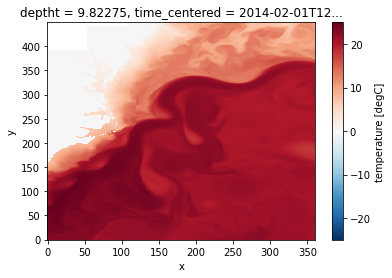

In [26]:
orca01w.thetao.isel(time_counter=0,deptht=7).plot()

In [9]:
orca01_grid = cat.ORCA36(region='1', datatype='grid', grid='meshmask').to_dask().isel(time_counter=0,y=slice(None,450))

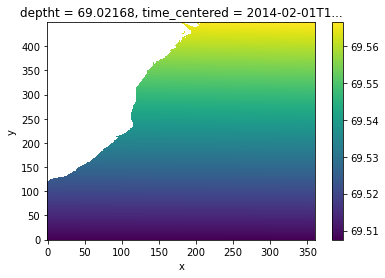

In [33]:
pres = xr.apply_ufunc(gsw.p_from_z, -orca01w.deptht, 
                      orca01w.nav_lat.where(xr.DataArray(orca01_grid.tmask.isel(nav_lev=slice(None,len(orca01w.deptht))).data,
                                                         dims=orca01w.so.isel(time_counter=0).dims, 
                                                         coords=orca01w.so.isel(time_counter=0).coords
                                                        )!=0.),
                      dask='parallelized', output_dtypes=[float,]
                     )
pres.isel(deptht=20).plot()

In [15]:
sig0w = xr.apply_ufunc(sw.dens0, 
                       orca01w.so.where(xr.DataArray(orca01_grid.tmask.isel(nav_lev=slice(None,len(orca01w.deptht))).data,
                                                     dims=orca01w.so.isel(time_counter=0).dims, 
                                                     coords=orca01w.so.isel(time_counter=0).coords
                                                    )!=0.),
                       orca01w.thetao.where(xr.DataArray(orca01_grid.tmask.isel(nav_lev=slice(None,len(orca01w.deptht))).data,
                                                         dims=orca01w.thetao.isel(time_counter=0).dims, 
                                                         coords=orca01w.thetao.isel(time_counter=0).coords
                                                        )!=0.),
                       dask='parallelized', output_dtypes=[float,]
                      ) - 1e3
sig0w

<xarray.DataArray (time_counter: 89, deptht: 47, y: 450, x: 361)>
dask.array<sub, shape=(89, 47, 450, 361), dtype=float64, chunksize=(2, 47, 450, 361), chunktype=numpy.ndarray>
Coordinates:
  * deptht        (deptht) float32 0.5058 1.556 2.668 ... 856.7 947.4 1.046e+03
    nav_lat       (y, x) float32 dask.array<chunksize=(450, 361), meta=np.ndarray>
    nav_lon       (y, x) float32 dask.array<chunksize=(450, 361), meta=np.ndarray>
  * time_counter  (time_counter) datetime64[ns] 2014-02-01T12:00:00 ... 2014-...
Dimensions without coordinates: y, x

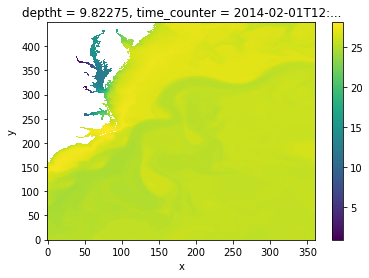

In [16]:
sig0w.isel(time_counter=0,deptht=7).plot()

In [17]:
sig0s = xr.apply_ufunc(sw.dens0, 
                       orca01s.so.where(xr.DataArray(orca01_grid.tmask.isel(nav_lev=slice(None,len(orca01s.deptht))).data,
                                                     dims=orca01s.so.isel(time_counter=0).dims, 
                                                     coords=orca01s.so.isel(time_counter=0).coords
                                                    )!=0.),
                       orca01s.thetao.where(xr.DataArray(orca01_grid.tmask.isel(nav_lev=slice(None,len(orca01s.deptht))).data,
                                                         dims=orca01s.thetao.isel(time_counter=0).dims, 
                                                         coords=orca01s.thetao.isel(time_counter=0).coords
                                                        )!=0.),
                       dask='parallelized', output_dtypes=[float,]
                      ) - 1e3
sig0s

<xarray.DataArray (time_counter: 92, deptht: 47, y: 450, x: 361)>
dask.array<sub, shape=(92, 47, 450, 361), dtype=float64, chunksize=(2, 47, 450, 361), chunktype=numpy.ndarray>
Coordinates:
  * deptht        (deptht) float32 0.5058 1.556 2.668 ... 856.7 947.4 1.046e+03
    nav_lat       (y, x) float32 dask.array<chunksize=(450, 361), meta=np.ndarray>
    nav_lon       (y, x) float32 dask.array<chunksize=(450, 361), meta=np.ndarray>
  * time_counter  (time_counter) datetime64[ns] 2013-08-01T12:00:00 ... 2013-...
Dimensions without coordinates: y, x

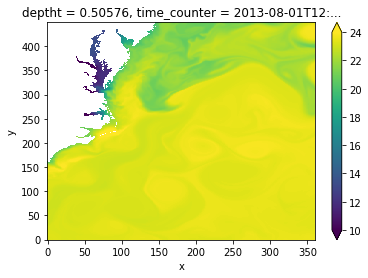

In [18]:
sig0s.isel(time_counter=0,deptht=0).plot(vmin=10, vmax=24)

In [19]:
tmp_path = f'{SCRATCH}/region01/ORCA36/'+f'sigma0_fma.zarr'
store_tmp = gcs.get_mapper(tmp_path)
sig0w.to_dataset(name='sig0').to_zarr(store_tmp, mode='w')

tmp_path = f'{SCRATCH}/region01/ORCA36/'+f'sigma0_aso.zarr'
store_tmp = gcs.get_mapper(tmp_path)
sig0s.to_dataset(name='sig0').to_zarr(store_tmp, mode='w')

# HYCOM50

In [27]:
def sig_hycom(s, t, nterm, pref):
    """
    hycom EOS output--sig2
    hycom EOS input == salinity/temperature/number of terms
    """

    if nterm==17:
#   -- 17/25 term
        c001= 9.9984085444849347E+02;    #!num. constant    coefficent
        c002= 7.3471625860981584E+00;    #!num.    T        coefficent
        c003=-5.3211231792841769E-02;    #!num.    T^2      coefficent
        c004= 3.6492439109814549E-04;    #!num.    T^3      coefficent
        c005= 2.5880571023991390E+00;    #!num.       S     coefficent
        c006= 6.7168282786692355E-03;    #!num.    T  S     coefficent
        c007= 1.9203202055760151E-03;    #!num.       S^2   coefficent
        c008= 1.0000000000000000E+00;    #!den. constant    coefficent
        c009= 7.2815210113327091E-03;    #!den.    T        coefficent
        c010=-4.4787265461983921E-05;    #!den.    T^2      coefficent
        c011= 3.3851002965802430E-07;    #!den.    T^3      coefficent
        c012= 1.3651202389758572E-10;    #!den.    T^4      coefficent
        c013= 1.7632126669040377E-03;    #!den.       S     coefficent
        c014= 8.8066583251206474E-06;    #!den.    T  S     coefficent
        c015= 1.8832689434804897E-10;    #!den.    T^3S     coefficent
        c016= 5.7463776745432097E-06;    #!den.    T  S^1.5 coefficent
        c017= 1.4716275472242334E-09;    #!den.    T^3S^1.5 coefficent
#
        c018= 1.1798263740430364E-02;    #!num. P           coefficent
        c019= 9.8920219266399117E-08;    #!num. P  T^2      coefficent
        c020= 4.6996642771754730E-06;    #!num. P     S     coefficent
        c021= 2.5862187075154352E-08;    #!num. P^2         coefficent
        c022= 3.2921414007960662E-12;    #!num. P^2T^2      coefficent
        c023= 6.7103246285651894E-06;    #!den. P           coefficent
        c024= 2.4461698007024582E-17;    #!den. P^2T^3      coefficent
        c025= 9.1534417604289062E-18;    #!den. P^3T        coefficent

        prs2pdb=1.E-4    ;   #!Pascals to dbar
        pref=pref*1.E4   ;   #!ref. pressure in Pascals, sigma2 (default: 2000.)
        rpdb=pref*prs2pdb;   #!ref. pressure in dbar

        c101=c001+(c018-c021*rpdb)*rpdb; #num. constant    coefficent
        c103=c003+(c019-c022*rpdb)*rpdb; #num.    T^2      coefficent
        c105=c005+c020*rpdb;             #num.       S     coefficent
        c108=c008+c023*rpdb;             #den. constant    coefficent
        c109=c009-c025*rpdb**3;          #den.    T        coefficent
        c111=c011-c024*rpdb**2;          #den.    T^3      coefficent

        sig_n = c101 + (t*(c002+t*(c103+t*c004)) 
                        + s*(c105-t*c006+s*c007));
        sig_d = c108 + (t*(c109+t*(c010+t*(c111+t*c012))) 
                        + s*(c013-t*(c014+t*t*c015) 
                             + np.maximum(0,s)**0.5*(c016+t*t*c017)
                            )
                       )
        aout = sig_n/sig_d - 1000.0;
        
    elif nterm==9:
        c1= 9.903308E+00;  #const. coefficent
        c2=-1.618075E-02;  #T      coefficent
        c3= 7.819166E-01;  #   S   coefficent
        c4=-6.593939E-03;  #T^2    coefficent
        c5=-2.896464E-03;  #T  S   coefficent
        c6= 3.038697E-05;  #T^3    coefficent
        c7= 3.266933E-05;  #T^2S   coefficent
        c8= 1.180109E-04;  #   S^2 coefficent
        c9= 3.399511E-06;  #T  S^2 coefficent
        aout = c1+s*(c3+s* c8)+ t*(c2+s*(c5+s*c9)+t*(c4+s*c7+t*c6)) 
    else:
        print('Unknown nterm (either 9 or 17)')
    
    return aout


In [18]:
hycom01w = cat.HYCOM50(region='1_GS', datatype='int', season='fma', decode_times=False).to_dask()
hycom01s = cat.HYCOM50(region='1_GS', datatype='int', season='aso', decode_times=False).to_dask()
hycom01_grid = cat.HYCOM50(region='1_GS', datatype='grid', grid='grid').to_dask()
hycom01w

<xarray.Dataset>
Dimensions:    (lat: 615, lay: 32, lon: 503, time: 90)
Coordinates:
  * time       (time) int64 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
Dimensions without coordinates: lat, lay, lon
Data variables:
    h3         (time, lay, lat, lon) float32 dask.array<chunksize=(24, 32, 615, 503), meta=np.ndarray>
    latitude   (lat) float32 dask.array<chunksize=(615,), meta=np.ndarray>
    layer      (lay) float32 dask.array<chunksize=(32,), meta=np.ndarray>
    longitude  (lon) float32 dask.array<chunksize=(503,), meta=np.ndarray>
    s3         (time, lay, lat, lon) float32 dask.array<chunksize=(24, 32, 615, 503), meta=np.ndarray>
    t3         (time, lay, lat, lon) float32 dask.array<chunksize=(24, 32, 615, 503), meta=np.ndarray>
    u3         (time, lay, lat, lon) float32 dask.array<chunksize=(24, 32, 615, 503), meta=np.ndarray>
    v3         (time, lay, lat, lon) float32 dask.array<chunksize=(24, 32, 615, 503), meta=np.ndarray>

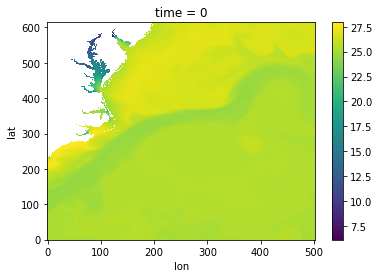

In [28]:
sig0w = xr.apply_ufunc(sig_hycom, hycom01w.s3.chunk({'lat':100,'lon':100}), 
                       hycom01w.t3.chunk({'lat':100,'lon':100}), 17, 0.,
                       dask='parallelized', output_dtypes=[float,]
)
sig0w.isel(time=0,lay=0).plot()

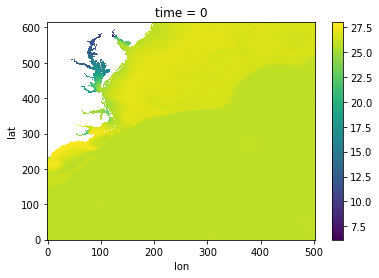

In [29]:
sig0w.isel(time=0,lay=10).plot()

In [25]:
sig0s = xr.apply_ufunc(sig_hycom, hycom01s.s3.chunk({'lat':100,'lon':100}), 
                       hycom01s.t3.chunk({'lat':100,'lon':100}), 17, 0.,
                       dask='parallelized', output_dtypes=[float,]
)

In [26]:
tmp_path = f'{SCRATCH}/region01/HYCOM50/'+f'sigma0_fma.zarr'
store_tmp = gcs.get_mapper(tmp_path)
sig0w.to_dataset(name='sig0').to_zarr(store_tmp, mode='w')

tmp_path = f'{SCRATCH}/region01/HYCOM50/'+f'sigma0_aso.zarr'
store_tmp = gcs.get_mapper(tmp_path)
sig0s.to_dataset(name='sig0').to_zarr(store_tmp, mode='w')

# FESOM

In [7]:
fesom01w = cat.FESOM(datatype='int', season='fma').to_dask().chunk({'lat':200,'lon':200})
# fesom01s = cat.FESOM(datatype='int', season='aso').to_dask()
fesom01w

<xarray.Dataset>
Dimensions:  (depth: 48, lat: 1000, lon: 1000, time: 90)
Coordinates:
  * depth    (depth) float64 0.0 -5.0 -10.0 -15.0 ... -760.0 -860.0 -1.04e+03
  * lat      (lat) float64 30.0 30.01 30.02 30.03 ... 39.97 39.98 39.99 40.0
  * lon      (lon) float64 -78.0 -77.99 -77.98 -77.97 ... -68.02 -68.01 -68.0
  * time     (time) datetime64[ns] 2012-02-01 2012-02-02 ... 2012-04-30
Data variables:
    salt     (time, depth, lat, lon) float32 dask.array<chunksize=(10, 48, 200, 200), meta=np.ndarray>
    temp     (time, depth, lat, lon) float32 dask.array<chunksize=(10, 48, 200, 200), meta=np.ndarray>
    u        (time, depth, lat, lon) float32 dask.array<chunksize=(10, 48, 200, 200), meta=np.ndarray>
    v        (time, depth, lat, lon) float32 dask.array<chunksize=(10, 48, 200, 200), meta=np.ndarray>
    w        (time, depth, lat, lon) float32 dask.array<chunksize=(10, 48, 200, 200), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.6 (http://mpimet.mpg.de/...
    CDO:          Climate Data Operators version 1.9.6 (http://mpimet.mpg.de/...
    Conventions:  CF-1.6
    history:      Thu Sep 09 15:44:25 2021: cdo mergetime 2012-02_01_w_cubic....

In [8]:
sig0w = xr.apply_ufunc(sw.dens0, 
                       fesom01w.salt.where(fesom01w.salt>32.).where(fesom01w.salt<38.), 
                       fesom01w.temp,
                       dask='parallelized', output_dtypes=[float,]
                      ) - 1e3
sig0w

<xarray.DataArray (time: 90, depth: 48, lat: 1000, lon: 1000)>
dask.array<sub, shape=(90, 48, 1000, 1000), dtype=float64, chunksize=(10, 48, 200, 200), chunktype=numpy.ndarray>
Coordinates:
  * depth    (depth) float64 0.0 -5.0 -10.0 -15.0 ... -760.0 -860.0 -1.04e+03
  * lat      (lat) float64 30.0 30.01 30.02 30.03 ... 39.97 39.98 39.99 40.0
  * lon      (lon) float64 -78.0 -77.99 -77.98 -77.97 ... -68.02 -68.01 -68.0
  * time     (time) datetime64[ns] 2012-02-01 2012-02-02 ... 2012-04-30

In [9]:
tmp_path = f'{SCRATCH}/region01/FESOM/'+f'sigma0_fma.zarr'
store_tmp = gcs.get_mapper(tmp_path)
sig0w.to_dataset(name='sig0').to_zarr(store_tmp, mode='w')